##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons Optimizers: ConditionalGradient


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href=""><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1UT4e-BZkpdsavgLXUpsCN5KEpAB3NY_b#scrollTo=b5P4BEg1XYd5"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pkan2/addons/blob/master/docs/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href=""><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Overview
This notebook will demonstrate how to use the Conditional Graident Optimizer from the Addons package.

# ConditionalGradient


> Constraining the parameters of a neural network has been shown to be beneficial in training because of the underlying regularization effects.  Often, parameters are constrained via a soft penalty (which never guarantees the constraint satisfaction) or via a projection operation (which is computationally expensive). Conditional gradient (CG) optimizer, on the other hand, enforces the constraints strictly without the need for an expensive projection step. It works by minimizing a linear approximation of the objective within the constraint set. In this notebook, we demonstrate the appliction of Frobenius norm constraint via the CG optimizer on the MNIST dataset. CG is now available as a tensorflow API. More details of the optimizer are available at https://arxiv.org/pdf/1803.06453.pdf


## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

In [0]:
!pip install --no-deps tensorflow-addons~=0.6

In [0]:
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# Hyperparameters
batch_size=64
epochs=10

# Build the Model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu', name='dense_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(10, activation='softmax', name='predictions'),
])

# Prep the Data

In [0]:
# Load MNIST dataset as NumPy arrays
dataset = {}
num_validation = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 784).astype('float32') / 255
x_test = x_test.reshape(-1, 784).astype('float32') / 255

# Define a Custom Callback Function

In [0]:
def frobenius_norm(m):
    """This function is to calculate the frobenius norm of the matrix of all
    layer's weight.
  
    Args:
        m: is a list of weights param for each layers.
    """
    total_reduce_sum = 0
    for i in range(len(m)):
        total_reduce_sum = total_reduce_sum + tf.math.reduce_sum(m[i]**2)
    norm = total_reduce_sum**0.5
    return norm

In [0]:
CG_frobenius_norm_of_weight = []
CG_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: CG_frobenius_norm_of_weight.append(
        frobenius_norm(model.trainable_weights).numpy()))

# Train and Evaluate: Using CG as Optimizer

Simply replace typical keras optimizers with the new tfa optimizer 

In [0]:
# Compile the model
model.compile(
    optimizer=tfa.optimizers.ConditionalGradient(
        learning_rate=0.99949, lambda_=203),  # Utilize TFA optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_cg = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[CG_get_weight_norm])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 76us/sample - loss: 0.3874 - accuracy: 0.8826 - val_loss: 0.2123 - val_accuracy: 0.9329
Epoch 2/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1947 - accuracy: 0.9412 - val_loss: 0.1657 - val_accuracy: 0.9509
Epoch 3/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1551 - accuracy: 0.9529 - val_loss: 0.1495 - val_accuracy: 0.9561
Epoch 4/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1341 - accuracy: 0.9593 - val_loss: 0.1263 - val_accuracy: 0.9609
Epoch 5/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1242 - accuracy: 0.9629 - val_loss: 0.1381 - val_accuracy: 0.9573
Epoch 6/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.1179 - accuracy: 0.9643 - val_loss: 0.1212 - val_accuracy: 0.9638
Epoch 7/10
60000/60000 [==============================] 

# Train and Evaluate: Using SGD as Optimizer

In [0]:
tf.keras.backend.clear_session()

In [0]:
SGD_frobenius_norm_of_weight = []
SGD_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: SGD_frobenius_norm_of_weight.append(
        frobenius_norm(model.trainable_weights).numpy()))

In [0]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(0.01),  # Utilize SGD optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_sgd = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[SGD_get_weight_norm])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0640 - accuracy: 0.9825 - val_loss: 0.0730 - val_accuracy: 0.9778
Epoch 2/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0574 - accuracy: 0.9844 - val_loss: 0.0720 - val_accuracy: 0.9782
Epoch 3/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0537 - accuracy: 0.9857 - val_loss: 0.0699 - val_accuracy: 0.9788
Epoch 4/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0511 - accuracy: 0.9865 - val_loss: 0.0683 - val_accuracy: 0.9785
Epoch 5/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0488 - accuracy: 0.9874 - val_loss: 0.0682 - val_accuracy: 0.9787
Epoch 6/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0468 - accuracy: 0.9878 - val_loss: 0.0661 - val_accuracy: 0.9796
Epoch 7/10
60000/60000 [==============================] 

# Frobenius Norm of Weights: CG vs SGD

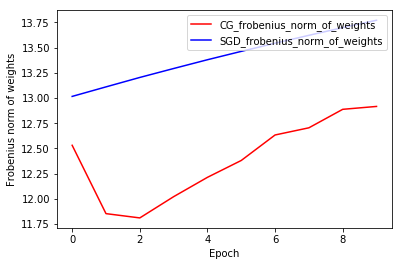

In [0]:
plt.plot(
    CG_frobenius_norm_of_weight,
    color='r',
    label='CG_frobenius_norm_of_weights')
plt.plot(
    SGD_frobenius_norm_of_weight,
    color='b',
    label='SGD_frobenius_norm_of_weights')
plt.xlabel('Epoch')
plt.ylabel('Frobenius norm of weights')
plt.legend(loc=1)

# Train and Validation Accuracy: CG vs SGD


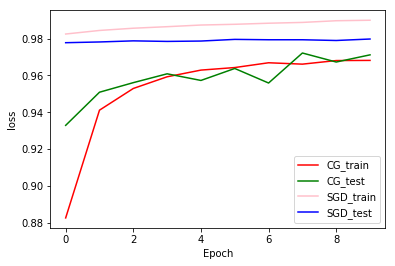

In [0]:
plt.plot(history_cg.history['accuracy'], color='r', label='CG_train')
plt.plot(history_cg.history['val_accuracy'], color='g', label='CG_test')
plt.plot(history_sgd.history['accuracy'], color='pink', label='SGD_train')
plt.plot(history_sgd.history['val_accuracy'], color='b', label='SGD_test')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc=4)